### torchvision - imgae
### torchtext - text

In [1]:
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader

BATCH_SIZE = 128

def get_dataloader(train=True): # train or test
    transform_fn = Compose([
        ToTensor(),
        Normalize(mean=(0.1307,), std=(0.3081,))
    ])

    # 1. load data
    dataset = MNIST(root='./data', train=train, download=False, transform=transform_fn)
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return data_loader

# for i in enumerate(get_dataloader()):
#     print(i)

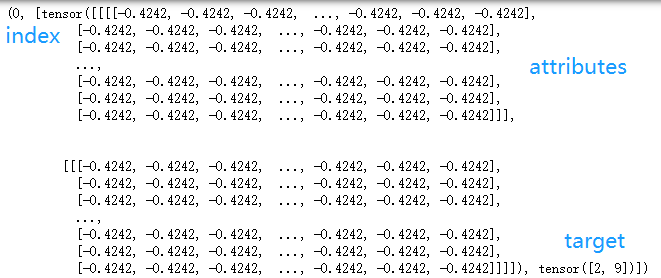

**original data:** [batch_size, 1, 28, 28]
<br>**input layer (change to):** [batch_size, 28\*28] (28\*28 pixels for each image)
<br>**first complete layer output:** [batch_size, 28] (28 rows in each image)
<br>**second complete layer output:** [batch_size, 10] (10 digits)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create model
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.fc1 = nn.Linear(1*28*28, 28)
        self.fc2 = nn.Linear(28, 10)
    def forward(self, Input):
        # change shape
        x = Input.view([-1, 1*28*28]) # or input.view([input.size(0), 1*28*28])
        # conduct full-connect
        x = self.fc1(x)
        # activate function, does not change shape
        x = F.relu(x)
        # output
        out = self.fc2(x) # predict value
        # loss function, cannot use sigmoid since this is not a binary classification
        return F.log_softmax(out, dim=-1)

In [3]:
from torch.optim import Adam
import os

model = MnistModel()
optimizer = Adam(model.parameters(), lr=0.001)
if os.path.exists('./model/MNIST_model.pkl'):
    # load model
    model.load_state_dict(torch.load('./model/MNIST_model.pkl'))
    # load optimizer
    optimizer.load_state_dict(torch.load('./model/MNIST_optimizer.pkl'))

def train(epoch):
    data_loader = get_dataloader() # training data
    for idx, (Input, target) in enumerate(data_loader):
        optimizer.zero_grad()
        predict = model(Input)
        loss = F.nll_loss(predict, target) # cross entropy loss
        loss.backward()
        optimizer.step()
        if idx%100 == 0:
            print(epoch, idx, loss.item())
        ##save model
        if idx%100 == 0:
            # 1. save model parameters
            torch.save(model.state_dict(), './model/MNIST_model.pkl')
            # 2, save optimizer
            torch.save(optimizer.state_dict(), './model/MNIST_optimizer.pkl')

In [4]:
for i in range(3):
    train(i)

0 0 2.291532278060913
0 100 0.44623640179634094
0 200 0.3220866918563843
0 300 0.26467859745025635
0 400 0.2158871740102768
1 0 0.24988064169883728
1 100 0.29647529125213623
1 200 0.1639454960823059
1 300 0.20270989835262299
1 400 0.12183594703674316
2 0 0.22746887803077698
2 100 0.17335422337055206
2 200 0.2377059906721115
2 300 0.15283042192459106
2 400 0.1907428503036499


In [5]:
# using loaded model and optimizer
for i in range(3):
    train(i)
# better result

0 0 0.2586457431316376
0 100 0.11017020791769028
0 200 0.08787909150123596
0 300 0.15802842378616333
0 400 0.1623450219631195
1 0 0.14528661966323853
1 100 0.15228904783725739
1 200 0.05206620693206787
1 300 0.13837866485118866
1 400 0.07677438855171204
2 0 0.22036448121070862
2 100 0.11899016797542572
2 200 0.1041368618607521
2 300 0.14468631148338318
2 400 0.0886652022600174


### model evaluation (loss and accuracy)

In [7]:
import numpy as np

def test():
    test_dataloader = get_dataloader(False)
    loss_list = []
    acc_list = []
    for idx, (Input, target) in enumerate(test_dataloader):
        with torch.no_grad():
            # get predict value
            predict = model(Input) # [batch_size, 10]
            # calculate loss
            cur_loss = F.nll_loss(predict, target)
            # calculate accuracy, predict size [batch_size, 10], target size [batch_size]
            pred = predict.max(dim=-1)[-1] # max in each row, predict label
            cur_acc = pred.eq(target).float().mean()
            # add to storing list
            loss_list.append(cur_loss)
            acc_list.append(cur_acc)
    print(f'mean accuracy: {np.mean(acc_list)}, mean loss: {np.mean(loss_list)}')

In [8]:
test()

mean accuracy: 0.9592563509941101, mean loss: 0.13311269879341125
